In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
import scipy.stats as stats
from bayes_ensemble import get_df_log_pars
from scoringrules import crps_lognormal, crps_normal

In [2]:
import sys
sys.path.append('../')
from utils import *

In [3]:
df_preds_all, models_by_state, data_all = load_preds(rename = False)

df_preds_all = df_preds_all.loc[df_preds_all.model_id.isin(['21', '22', '25', '26', '27', '28', '30', '34'] )]

df_preds_all['model_id'] = df_preds_all['model_id'].astype(int)

df_preds_all.head()

,date,pred,lower,upper,state,model_id
0,2022-10-09,110.690113,64.291013,219.826948,AC,21
2800,2025-08-10,192.641953,142.814506,261.828157,PR,21
2801,2025-08-17,171.137457,119.943438,233.918928,PR,21
2802,2025-08-24,196.875395,132.696765,267.461459,PR,21
2803,2025-08-31,179.610112,136.303073,247.230651,PR,21


In [15]:
state = 'MG'
data_23, data_24, preds_23, preds_24, preds_25, models = format_data(state, models_by_state, data_all, df_preds_all)
preds_23 = preds_23.loc[preds_23.model_id == 30].reset_index(drop = True)
data_23 = data_23.sort_values(by = 'date')
preds_23 = preds_23.sort_values(by = 'date')
preds_23.head()

/Users/eduardoaraujo/Documents/Github/Dengue-Forecast-Ensemble/bayes_ensemble/../utils.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds.date = pd.to_datetime(preds.date)


,date,pred,lower,upper,state,model_id
36,2022-10-09,719.0,297.95,4253.65,MG,30
37,2022-10-16,774.5,325.85,4272.15,MG,30
38,2022-10-23,841.0,343.90,4784.25,MG,30
39,2022-10-30,883.0,360.95,5052.80,MG,30
40,2022-11-06,968.0,396.00,5489.85,MG,30


### Scores - normal - mosqlient package: 

In [16]:
confidence_level = 0.9 
z_value = stats.norm.ppf((1 + confidence_level) / 2)

In [17]:
score_norm = crps_normal(data_23.casos, preds_23.pred, (preds_23.upper - preds_23.lower) / (2 * z_value))

### Scores - lognormal: 

In [23]:
pred_log = get_df_log_pars(preds_23[['date', 'pred', 'lower', 'upper']].reset_index(drop= True), fn_loss = 'median')

pred_log.head()

,date,pred,lower,upper,mu,sigma,fit_med,fit_lwr,fit_upr
0,2022-10-09,719.0,297.95,4253.65,6.577862,1.080748,719.000116,121.533495,4253.651773
1,2022-10-16,774.5,325.85,4272.15,6.652218,1.038181,774.499940,140.409359,4272.152219
2,2022-10-23,841.0,343.90,4784.25,6.734592,1.056929,840.999963,147.835234,4784.251481
3,2022-10-30,883.0,360.95,5052.80,6.783325,1.060504,882.999734,154.308186,5052.800851
4,2022-11-06,968.0,396.00,5489.85,6.875232,1.055063,967.999553,170.682811,5489.850619


pred_log = get_df_log_pars(preds_23[['date', 'pred', 'lower', 'upper']].reset_index(drop= True), fn_loss = 'lower')

pred_log.head()

In [24]:
score_log = crps_lognormal(data_23.casos.values, pred_log.mu, pred_log.sigma)

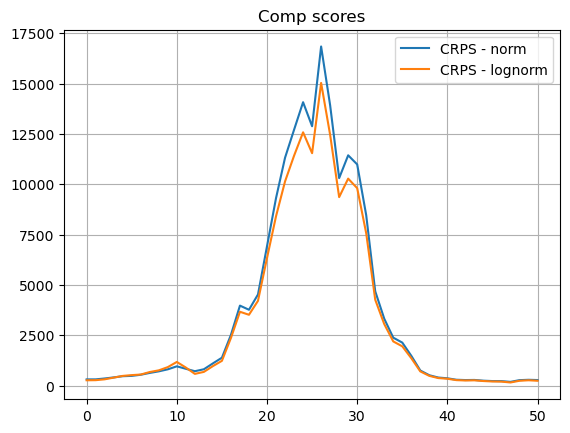

In [25]:
fig,ax = plt.subplots()

ax.plot(score_norm, label = 'CRPS - norm')
ax.plot(score_log, label = 'CRPS - lognorm')

ax.grid()
ax.legend()
ax.set_title('Comp scores')
plt.show()

In [26]:
np.mean(score_norm)

3596.9487957471665

In [27]:
np.mean(score_log)

3264.6887011753374